In [1]:
%load_ext autoreload
%autoreload 2
import qim3d
import scipy.ndimage as ndim
import numpy as np
import skimage as sk

This notebook serves as an example on how to use qim3d library and what are the possibilities. All thresholds and other number are arbitrary and chosen after series of trials and errors.

### Our goal is to segment the teeth from the deer mandible scan available [here](https://data.qim.dk/pages/deer_mandible.html)

# Downloading and loading the data

If you have not downloaded the data yet you can do it via the Downloader. It is a convenient way to download the data in the same folder that this notebook is in and load immediately afterwards. 
If you are unsure what files you can download, you can list them all with `list_files`. These files are not installed by qim3d library by default, so you don't have to worry about your disk space

In [2]:
downloader = qim3d.io.Downloader()
downloader.list_files()


╭──────╮
│ Coal │
╰──────╯
Coal.CoalBrikett                                  (2.24GB)
Coal.CoalBrikettZoom_DOWNSAMPLED                  (238.50MB)
Coal.CoalBrikett_Zoom                             (3.73GB)

╭────────╮
│ Corals │
╰────────╯
Corals.Coral_1                                    (2.27GB)
Corals.Coral_2                                    (2.38GB)
Corals.Coral2_DOWNSAMPLED                         (152.66MB)
Corals.Coral_1_1                                  (1.83GB)
Corals.Coral_1_2                                  (1.83GB)
Corals.Coral_1_3                                  (1.83GB)
Corals.MexCoral                                   (2.24GB)

╭─────────────╮
│ Cowry_Shell │
╰─────────────╯
Cowry_Shell.Cowry_DOWNSAMPLED                     (116.91MB)
Cowry_Shell.Cowry_Shell                           (1.83GB)

╭──────╮
│ Crab │
╰──────╯
Crab.HerrmitCrab                                  (2.38GB)
Crab.OkinawaCrab                                  (1.86GB)

╭───────────────╮
│ Deer_Man

In [3]:
data = downloader.Deer_Mandible.DeerMandible_DOWNSAMPLED(load_file = True)

File already downloaded:
/home/s233039/Desktop/qim-notebooks/processing/Deer_Mandible/DeerMandible_DOWNSAMPLED.tif

Loading DeerMandible_DOWNSAMPLED.tif
Using virtual stack


# Exploring the data

One of the biggest strengths of qim3d library is how easy you can explore data using `volumetric`, `slicer` and `slicer_orthogonal`. Let's use that so we can see what we are dealing with. 

Volumetric downsamples the data by default so it can be properly rendered. If the downsampling is not strong enough or you think your computer could handle bigger load, use the argument `max_voxels`. Our default value is $128^3$

In [4]:
qim3d.viz.volumetric(data)

Downsampled image for visualization, from (750, 450, 992) to (277, 166, 366)


Output()

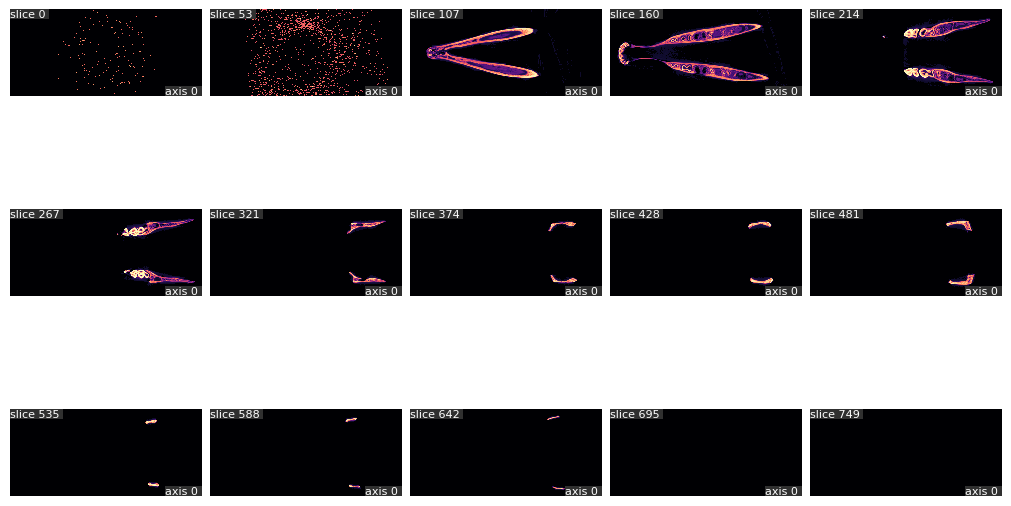

In [5]:
qim3d.viz.slices_grid(data)

Lte's clean the data from the obstructing black fog

In [6]:
data[data < 5000] = 0
qim3d.viz.volumetric(data)

Downsampled image for visualization, from (750, 450, 992) to (277, 166, 366)


Output()

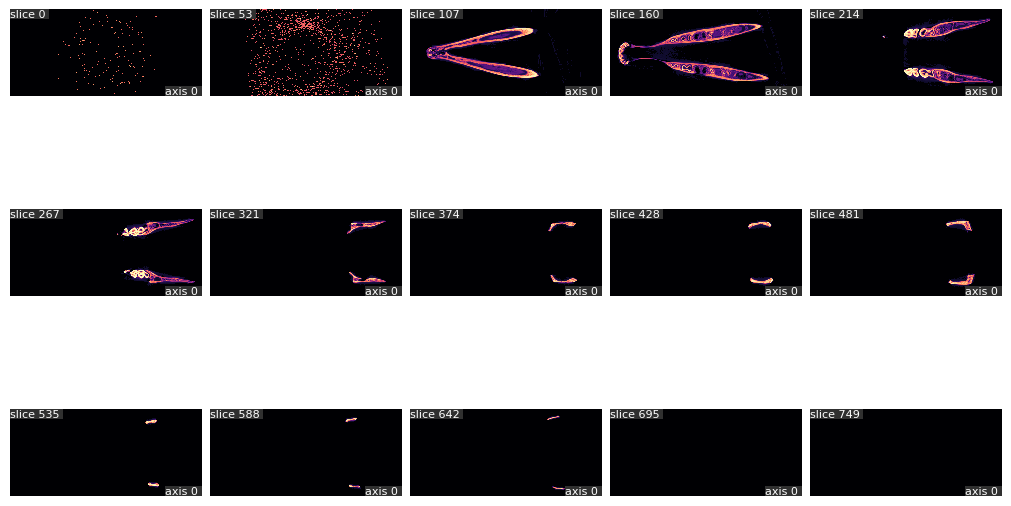

In [7]:
qim3d.viz.slices_grid(data)

In [8]:
qim3d.viz.slicer_orthogonal(data)

### Separating regions of interest
The downsampling is pretty strong and we loose a lot of details. However, we can still see a clear distinction between the incisiors (front teeth) and molars/premolars (rear teeth). Given there is clear shape and size difference and the groups are quite far away from each other, we will split the volume into two regions of interest and work with them separately. That will allow us to work with smaller volumes which will improve processing time and zoom more closely with vizualization tools

In [9]:
molars = data[100:350, 80:370, 250:750]
incisiors = data[80:190, 150:300, :150] 

# Molars (rear teeth)

In [10]:
qim3d.viz.volumetric(molars)

Downsampled image for visualization, from (250, 290, 500) to (193, 224, 387)


Output()

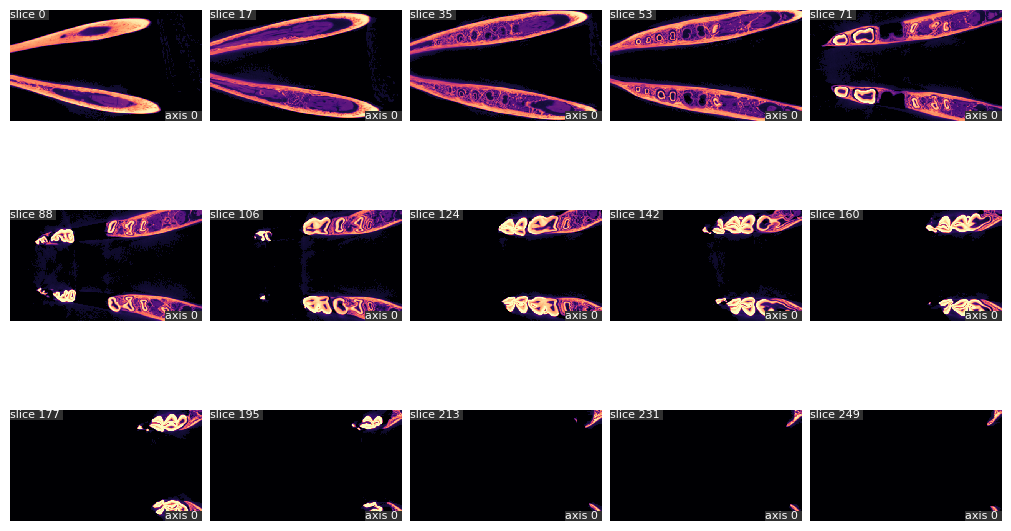

In [11]:
qim3d.viz.slices_grid(molars)

When using orthogonal slicer, the slicer through y axis goes into the middle slice by default. But there is nothing. To avoid the necesity to move the slider everytime we update the cell, we can specify the starting slice. Then we need to see what are the intensity values on the slices. We can specify which slicers should display colorbars next to them.

In [13]:
qim3d.viz.slicer_orthogonal(molars, colorbar='volume', default_y=40)

## Why not global threshold

It is clear that the teeth have higher intensity compare to the rest of the bone and thus easy solution might be a global threshold. However, some parts of the bone are also high in intensity. On the other hand roots of the teeth don't have such high number and this method wouldn't segment them properly. Let's look at how it would look like

In [14]:
global_threshold = 55000
thresholded_molars = molars > global_threshold
qim3d.viz.volumetric(thresholded_molars)

Downsampled image for visualization, from (250, 290, 500) to (193, 224, 387)


Output()

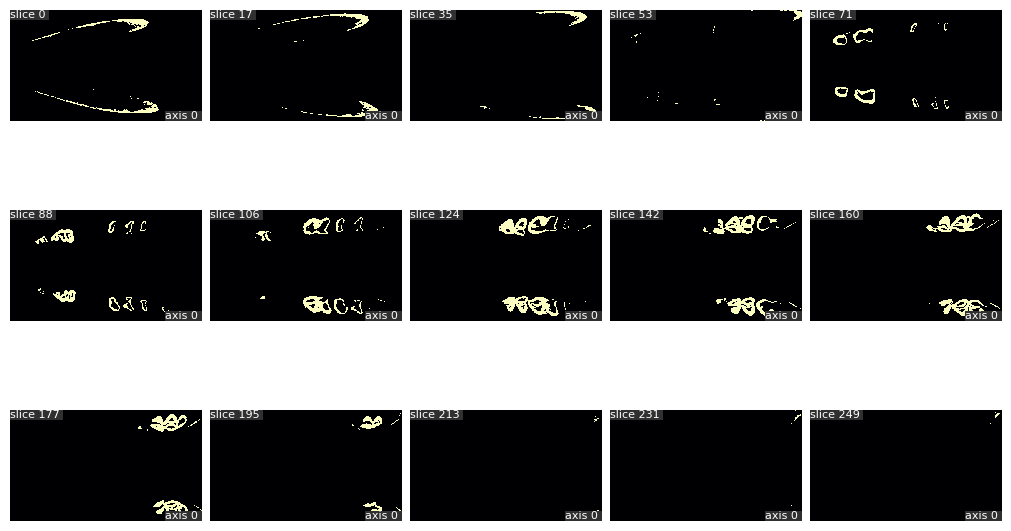

In [15]:
qim3d.viz.slices_grid(thresholded_molars)

## Edge based approach
The approach we chose is based on finding edges of the teeth and the filling them up.

We will find edges in the whole image using the sobel filter.

We need to normalize the values because with this size we might face overflowing the range of unsigned short.

In [17]:
input = (255*(molars/molars.max())).astype('int32')
sob = qim3d.filters.sobel(input)
sob*= 255/sob.max()
qim3d.viz.slicer_orthogonal(sob, colorbar = 'volume')


Use only the more prominent edges and make them a little bit thicker

In [18]:
edges = sob>120
dilated_edges = ndim.binary_dilation(edges)

qim3d.viz.slicer_orthogonal(edges)

There is a lot of smaller edges that are not connected to anything and edges from the mandible itself. Thus we get rid of everything too small

In [19]:
# Deleting all labels not containing enough voxels
labeled_edges, _ = ndim.label(edges)
unique, counts = np.unique(labeled_edges, return_counts=True)
minimum_volume = 1000
# labels = np.extract(counts > minimum_volume, unique)
labels = unique[counts > minimum_volume]
labeled_edges = np.where(np.isin(labeled_edges, labels), labeled_edges, 0)

# Renumbering labels
unique = np.unique(labeled_edges)
new_labeled_edges = np.zeros_like(labeled_edges)
for index, label in enumerate(unique[1:]):
    new_labeled_edges += (index+1)*(labeled_edges==label)
labeled_edges = new_labeled_edges

In [21]:
cmap = qim3d.viz.colormaps.segmentation(len(unique)-1)
qim3d.viz.slicer_orthogonal(labeled_edges, colormap=cmap)

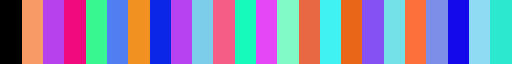

In [22]:
cmap

And now we delete the segmentation of the mandible. We can identify the labels based on the size and color.

In [23]:
np.unique(labeled_edges, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23], dtype=int32),
 array([35820931,    89166,    73920,     1030,     1595,    16883,
            2954,     1156,     6054,     2942,     5337,     1282,
           85103,    17596,     2055,     3581,    85745,     6336,
            1248,     4413,     1051,     8543,     2407,     8672]))

In [24]:
for i in [1, 2, 3, 4]: # Indices of the mandible segmentation
    labeled_edges[labeled_edges == i] = 0

We can now take the resulting edges and make them a little thicker.

In [25]:
dilated_edges = ndim.binary_dilation(labeled_edges)
dilated_edges = ndim.binary_dilation(dilated_edges)
qim3d.viz.slicer_orthogonal(molars, mask = dilated_edges)

If all we want are outer edges, our goal is done. However, most usecases would require segmenting the whole teeth.
We need to get manual seed-points and use floodfill on the sobel-filtered image. That will fill up the inner part of the teeth without overstepping the edges. Why use the edges then? The roots of the teeth are mostly only thin edges. The floodfill would not segment those.

In [26]:
blur_sob = qim3d.filters.gaussian(sob, 0.8)
rear_right = (120, 50, 270)
rear_left = (115, 240, 270)
front_right1 = (79, 80, 73)
front_right2 = (101, 63, 133)
front_left1 = (79, 211, 79)
front_left2 = (97, 228, 139)
seed_points = [rear_left, rear_right, front_right1, front_right2, front_left1, front_left2]
segmentation = dilated_edges.copy()
for seed_point in seed_points:
    insides = sk.segmentation.flood(blur_sob, seed_point, tolerance = 20)
    segmentation = segmentation + insides


Finally we check that we segmented what we wanted

In [27]:
qim3d.viz.slicer_orthogonal(molars, mask= segmentation)

In [28]:
c = molars.copy()
c[~segmentation] = 0
qim3d.viz.volumetric(c)

Downsampled image for visualization, from (250, 290, 500) to (193, 224, 387)


Output()

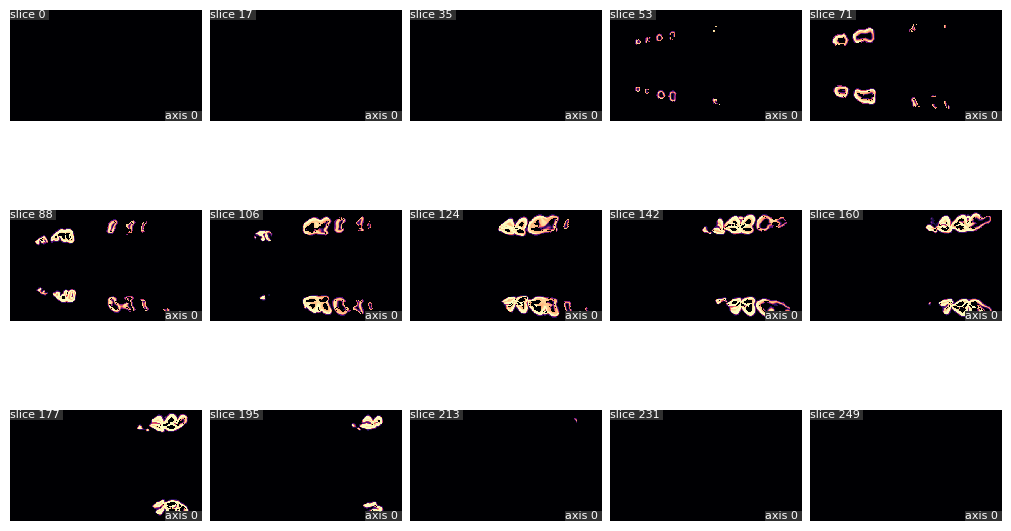

In [29]:
qim3d.viz.slices_grid(c)

In [31]:
wat, num_labels = qim3d.segmentation.watershed(segmentation, min_distance=35)
cmap = qim3d.viz.colormaps.segmentation(num_labels)
qim3d.viz.volumetric(wat, colormap = cmap)


Total number of objects found: 11
Downsampled image for visualization, from (250, 290, 500) to (193, 224, 387)


Output()

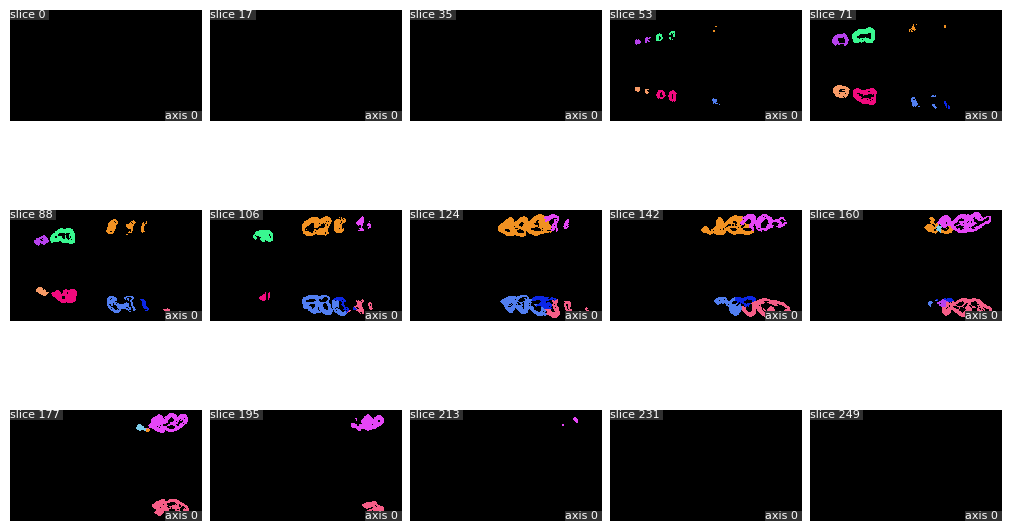

In [32]:
qim3d.viz.slices_grid(wat, colormap= cmap)

# Incisiors (front teeth)

In [33]:
qim3d.viz.volumetric(incisiors)

Output()

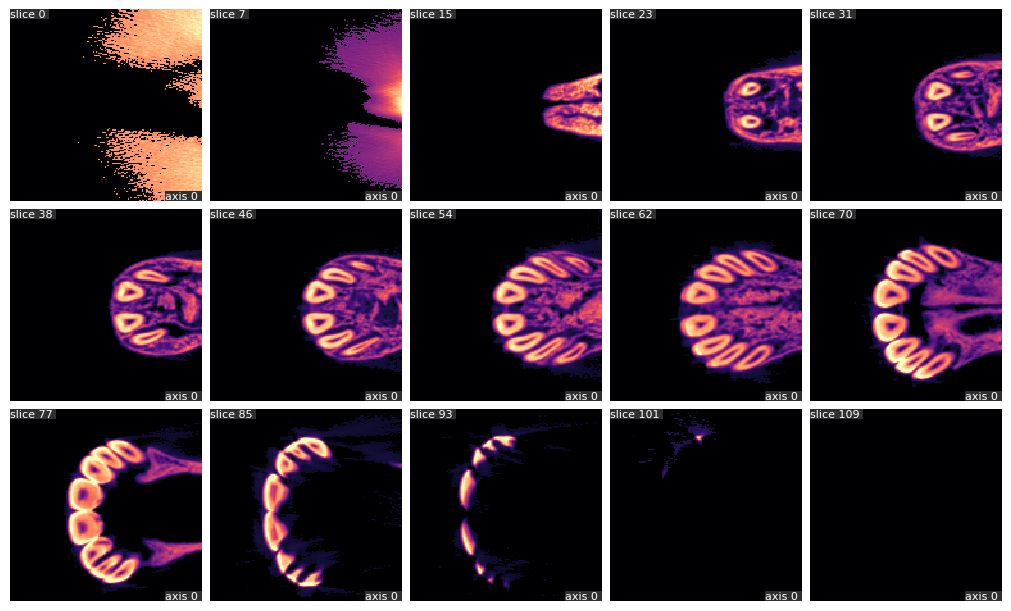

In [34]:
qim3d.viz.slices_grid(incisiors)

In [35]:
qim3d.viz.slicer_orthogonal(incisiors, colorbar = 'volume')

The difference between teeth and the bone is much larger in this case. Thus the we can apply simple thresholding and then process the result with some morphological operations.

In [ ]:
import qim3d.filters as f

pipeline = f.Pipeline(
    f.Gaussian(sigma=0.1),
    f.Threshold(threshold=40000),
    f.Filter(ndim.binary_dilation, structure=sk.morphology.ball(1), save_output = True),
    f.Filter(ndim.binary_fill_holes),
    f.Filter(ndim.binary_erosion, structure=sk.morphology.ball(5)),
)
pipeline_output = pipeline(incisiors)
segmentation = ndim.binary_propagation(pipeline_output, mask = pipeline.saved_outputs[0])
qim3d.viz.slicer_orthogonal(incisiors, mask = segmentation)


In [38]:
incisiors_copy = incisiors.copy()
incisiors_copy[~segmentation] = 0
qim3d.viz.volumetric(incisiors_copy)


Output()

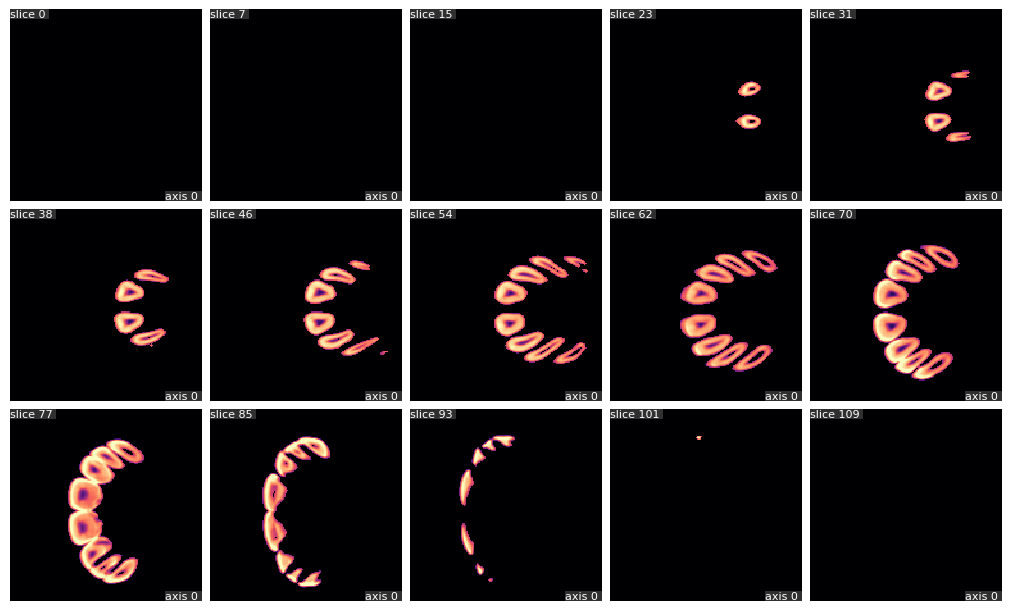

In [39]:
qim3d.viz.slices_grid(incisiors_copy)

In [41]:
labeled_volume, num_labels = qim3d.segmentation.watershed(segmentation, min_distance = 9)
cmap = qim3d.viz.colormaps.segmentation(num_labels)
qim3d.viz.volumetric(labeled_volume, colormap=cmap)

Total number of objects found: 9


Output()

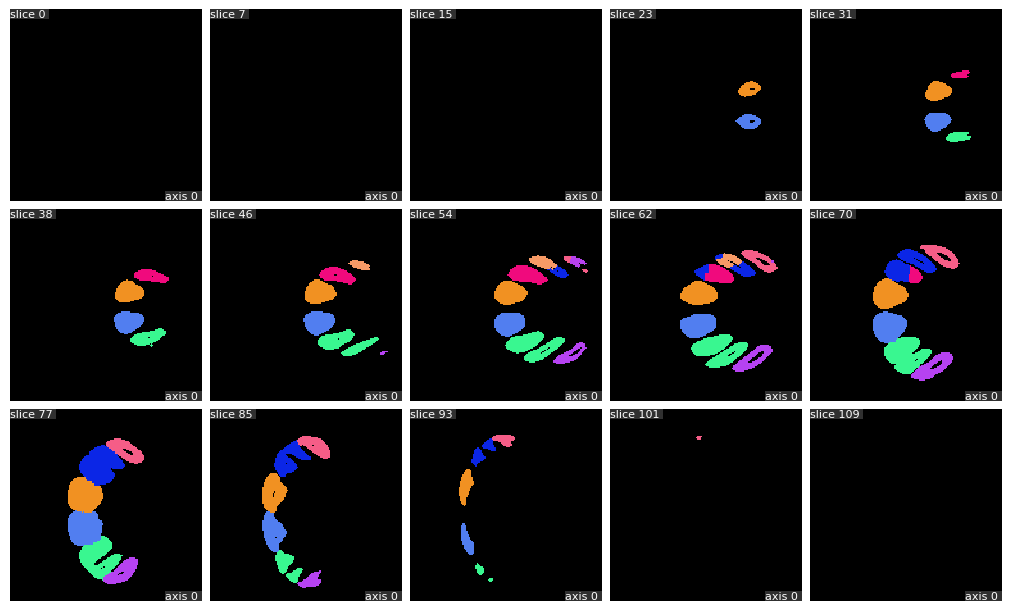

In [43]:
qim3d.viz.slices_grid(labeled_volume, colormap = cmap)